In [1]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
import pandas as pd

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt

# Data loading and preparation

In [6]:
edges = pd.read_csv("../data/interim/edges.csv")

In [3]:
# noisy = pd.read_csv("../data/interim/noisy_cells.csv")

In [4]:
# noisy =  noisy["cell.names"]

In [8]:
# edges = edges[~edges.node1.isin(noisy)]

In [7]:
edges[edges.type == "sc2vis"][edges[edges.type == "sc2vis"].celltype_major.isna()]

Empty DataFrame
Columns: [Unnamed: 0, node1, node2, type, celltype_major, celltype_minor, clone]
Index: []

In [8]:
overcl = pd.read_csv("../data/interim/clones.csv")

In [9]:
overcl.columns = ["node1","clone"]

In [10]:
overcl.clone.unique()

array(['3', '5', 'diploid', '2', '6', '7', '1', '0', '4'], dtype=object)

In [11]:
edges = edges.drop(columns = ["clone"])


In [12]:
overcl = edges[edges["type"] == "sc2vis"].merge(overcl,left_on = "node1",right_on ="node1",how = "left")

In [13]:
overcl.clone = overcl.clone.fillna("diploid")

In [14]:
overcl.clone.unique()

array(['diploid', '0', '3', '7', '1', '5', '6', '2', '4'], dtype=object)

In [15]:
edges= edges.merge(overcl[["clone","node1"]],left_on = "node1",right_on ="node1",how = "left")

In [16]:
emb_vis = pd.read_csv("../data/interim/embedding_visium_scvi.csv", index_col = 0)
emb_rna = pd.read_csv("../data/interim/embedding_rna2vis_scvi.csv", index_col = 0)

In [17]:
all_nodes_graph = set(edges.node1.to_list() + edges.node2.to_list())
all_nodes_emb = set(emb_vis.index).union(set(emb_rna.index))
all_nodes = list(all_nodes_graph.intersection(all_nodes_emb))
node_encoder = {all_nodes[i]:i for i in range(len(all_nodes))}
emb_vis = emb_vis.loc[emb_vis.index.isin(all_nodes)]
emb_rna = emb_rna.loc[emb_rna.index.isin(all_nodes)]

In [18]:
edges = edges[edges.node1.isin(all_nodes)]

In [19]:
edges = edges[edges.node2.isin(all_nodes)]

In [20]:
edges.node1 = edges.node1.map(node_encoder)

In [21]:
edges.node2 = edges.node2.map(node_encoder)

In [22]:
emb_vis = emb_vis.rename(index = node_encoder)
emb_rna = emb_rna.rename(index = node_encoder)

In [23]:
len(all_nodes)

34079

In [24]:
edge_index = torch.tensor([edges.node1,
                           edges.node2], dtype=torch.long)

In [25]:
features = pd.concat([emb_vis, emb_rna])

In [26]:
features = features.sort_index()

In [27]:
x = torch.tensor(features.values , dtype=torch.float)

In [28]:
edges[edges.type == "vis2grid"]

Unnamed: 0  node1  node2      type celltype_major celltype_minor  \
2908700      298910   8058  15067  vis2grid            NaN            NaN   
2908701      298911   8058  29139  vis2grid            NaN            NaN   
2908702      298912   9574  31866  vis2grid            NaN            NaN   
2908703      298913   9574   4087  vis2grid            NaN            NaN   
2908704      298914   9574  11816  vis2grid            NaN            NaN   
...             ...    ...    ...       ...            ...            ...   
2928253      318463  21204   7819  vis2grid            NaN            NaN   
2928254      318464  21204  18322  vis2grid            NaN            NaN   
2928255      318465  21204  11301  vis2grid            NaN            NaN   
2928256      318466  14497   6524  vis2grid            NaN            NaN   
2928257      318467  14497  30210  vis2grid            NaN            NaN   

        clone  
2908700   NaN  
2908701   NaN  
2908702   NaN  
2908703   NaN  
2908704   NaN  
...       ...  
2928253   NaN  
2928254   NaN  
2928255   NaN  
2928256   NaN  
2928257   NaN  

[19558 rows x 7 columns]

In [29]:
edges.clone = edges.clone.fillna("missing")

In [30]:
edges[edges.clone == "missing"]

Unnamed: 0  node1  node2      type celltype_major celltype_minor  \
2908700      298910   8058  15067  vis2grid            NaN            NaN   
2908701      298911   8058  29139  vis2grid            NaN            NaN   
2908702      298912   9574  31866  vis2grid            NaN            NaN   
2908703      298913   9574   4087  vis2grid            NaN            NaN   
2908704      298914   9574  11816  vis2grid            NaN            NaN   
...             ...    ...    ...       ...            ...            ...   
2928253      318463  21204   7819  vis2grid            NaN            NaN   
2928254      318464  21204  18322  vis2grid            NaN            NaN   
2928255      318465  21204  11301  vis2grid            NaN            NaN   
2928256      318466  14497   6524  vis2grid            NaN            NaN   
2928257      318467  14497  30210  vis2grid            NaN            NaN   

           clone  
2908700  missing  
2908701  missing  
2908702  missing  
2908703  missing  
2908704  missing  
...          ...  
2928253  missing  
2928254  missing  
2928255  missing  
2928256  missing  
2928257  missing  

[19558 rows x 7 columns]

In [31]:
nodes_atr = edges[["node1","type","celltype_major", "clone"]].drop_duplicates()

In [32]:
nodes_atr = nodes_atr.sort_values(by = "node1")

In [33]:
nodes_atr.clone.unique()

array(['5', 'diploid', '0', '1', '2', '4', 'missing', '6', '7', '3'],
      dtype=object)

In [34]:
nodes_atr.celltype_major = nodes_atr.celltype_major.fillna("missing")

In [35]:
nodes_atr

node1    type     celltype_major    clone
436400       0  sc2vis  Cancer Epithelial        5
2121000      1  sc2vis  Normal Epithelial  diploid
1120600      2  sc2vis  Normal Epithelial        5
1020500      3  sc2vis  Normal Epithelial  diploid
2229000      4  sc2vis  Normal Epithelial        0
...        ...     ...                ...      ...
1201900  34074  sc2vis  Cancer Epithelial        3
2605400  34075  sc2vis            Myeloid  diploid
1323800  34076  sc2vis  Normal Epithelial        1
210600   34077  sc2vis       Plasmablasts  diploid
1960900  34078  sc2vis  Cancer Epithelial        1

[34079 rows x 4 columns]

In [36]:
from collections import Counter

Counter(nodes_atr.celltype_major)

Counter({'Cancer Epithelial': 8503,
         'Normal Epithelial': 4033,
         'T.cells': 5983,
         'Myeloid': 3868,
         'CAFs': 2592,
         'missing': 4992,
         'Endothelial': 1346,
         'PVL': 469,
         'Plasmablasts': 1275,
         'B.cells': 1018})

In [37]:
ct_list = list(nodes_atr.celltype_major.unique())
ct_list.remove("missing")

In [38]:
Counter(nodes_atr.clone)

Counter({'5': 808,
         'diploid': 19615,
         '0': 2673,
         '1': 1953,
         '2': 1610,
         '4': 846,
         'missing': 4992,
         '6': 560,
         '7': 560,
         '3': 462})

In [39]:
clone_list = list(nodes_atr.clone.unique())
clone_list.remove("missing")
clone_list.remove("diploid")
clone_dict = {x:int(x) for x in clone_list}
clone_dict["missing"] = -1
clone_dict["diploid"] = len(clone_dict)-1

In [40]:
clone_dict

{'5': 5,
 '0': 0,
 '1': 1,
 '2': 2,
 '4': 4,
 '6': 6,
 '7': 7,
 '3': 3,
 'missing': -1,
 'diploid': 8}

In [41]:
type_dict = {ct_list[i]:i for i in range(len(ct_list))}

In [42]:
type_dict["missing"] = -1

In [43]:
type_dict

{'Cancer Epithelial': 0,
 'Normal Epithelial': 1,
 'T.cells': 2,
 'Myeloid': 3,
 'CAFs': 4,
 'Endothelial': 5,
 'PVL': 6,
 'Plasmablasts': 7,
 'B.cells': 8,
 'missing': -1}

In [44]:
nodes_atr.clone = nodes_atr.clone.map(clone_dict)

In [45]:
edges.celltype_major = edges.celltype_major.fillna("missing")

In [46]:
nodes_atr.celltype_major = nodes_atr.celltype_major.map(type_dict)

In [47]:
nodes_atr = nodes_atr.set_index("node1")

In [48]:
nodes_atr.head()

type  celltype_major  clone
node1                               
0      sc2vis               0      5
1      sc2vis               1      8
2      sc2vis               1      5
3      sc2vis               1      8
4      sc2vis               1      0

In [49]:
features = features.join(nodes_atr)

In [50]:
features.clone = features.clone.fillna(-1)

In [51]:
features.celltype_major = features.celltype_major.fillna(-1)

In [52]:
y_clone = torch.tensor(features.clone.values,dtype=torch.long)


In [53]:
y_type = torch.tensor(features.celltype_major.values,dtype=torch.long)

In [54]:
y_type.unique()

tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [55]:
y_clone.unique()

tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [56]:
data = Data(x=x, edge_index=edge_index, y_clone = y_clone,y_type = y_type, edge_type = edges.type.values)

In [57]:
data.validate(raise_on_error=True)


True

In [58]:
hold_out = torch.tensor(np.where(data.y_clone == -1)[0],dtype=torch.long)

In [59]:
tot_size = data.x.shape[0] -len(hold_out)
train_size = int(0.8*tot_size)
hold_in = np.arange(data.x.shape[0])
hold_in = [x for x in hold_in if x not in  hold_out]

In [60]:
len(hold_out)

4992

In [61]:
data.y_type[hold_in].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [60]:
data.y_clone[hold_in].unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [62]:
from sklearn.model_selection import train_test_split

train_samp,test_samp,_,_ = train_test_split(hold_in,data.y_clone[hold_in], stratify = data.y_clone[hold_in], test_size=0.2, random_state=42)


In [63]:
data.train_mask = torch.tensor(train_samp,dtype=torch.long)
data.test_mask = torch.tensor(test_samp,dtype=torch.long)
data.hold_out = hold_out

In [64]:
data.train_mask = torch.tensor(train_samp,dtype=torch.long)
data.test_mask = torch.tensor(test_samp,dtype=torch.long)
data.hold_out = hold_out

In [65]:
y_train = data.y_type[data.train_mask]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight_type = 1. / class_sample_count

In [66]:
y_train = data.y_clone[data.train_mask]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
weight_clone = 1. / class_sample_count

In [67]:
weight_clone = torch.tensor(weight_clone, dtype=torch.float)
weight_type = torch.tensor(weight_type, dtype=torch.float)

In [68]:
len(edges.clone.unique())

10

In [69]:
data.num_classes_clone = len(y_clone.unique())
data.num_classes_type = len(y_type.unique())

In [70]:



class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 16)
        self.conv3 = GCNConv(16, 16)


        # self.conv_clone = GCNConv(16, data.num_classes_clone - 1)
        # self.conv_type = GCNConv(16, data.num_classes_type-1)
        self.out = GCNConv(16,data.num_classes_clone +  data.num_classes_type -2)


    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)

        x_pre = F.relu(x)
        x_out = self.out(x_pre, edge_index)


        return (x_out)

In [241]:
device = torch.device('cuda:0')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [242]:
weight_clone = weight_clone.to(device)
weight_type = weight_type.to(device)

In [243]:
data = data.to(device)


In [244]:
def test():
    model.eval()
    with torch.no_grad():
        pred = model(data.x, data.edge_index)
        pred_clone = pred[:,:data.num_classes_clone-1]
        pred_cell_type = pred[:,data.num_classes_clone-1:]
        pred_clone = F.log_softmax(pred_clone, dim=1)
        loss_clone = weighted_loss(pred_clone[data.test_mask], norm_sim, data.y_clone[data.test_mask],weight_clone)

        pred_clone = pred_clone.argmax(dim=1)
        pred_cell_type = F.log_softmax(pred_cell_type, dim=1)
        loss_ct = F.nll_loss(pred_cell_type[data.test_mask], data.y_type[data.test_mask], weight = weight_type)
        pred_cell_type = pred_cell_type.argmax(dim=1)

        correct_clones = (pred_clone[data.test_mask] == data.y_clone[data.test_mask]).sum()
        correct_types = (pred_cell_type[data.test_mask] == data.y_type[data.test_mask]).sum()

        acc_clone = int(correct_clones) / len(data.test_mask)
        acc_type = int(correct_types) / len(data.test_mask)
        

    
    # reducer = umap.UMAP()
    # emb = pred[-1].detach().numpy()
    # scaled_penguin_data = StandardScaler().fit_transform(emb)
    # embedding = reducer.fit_transform(scaled_penguin_data)
    # sns.scatterplot(x = embedding[:, 0], y = embedding[:, 1], hue = data.node_type)
    # plt.show()
        return(acc_clone,acc_type, loss_clone,loss_ct)

In [245]:
norm_sim = np.load("../data/interim/clone_dist.npy")

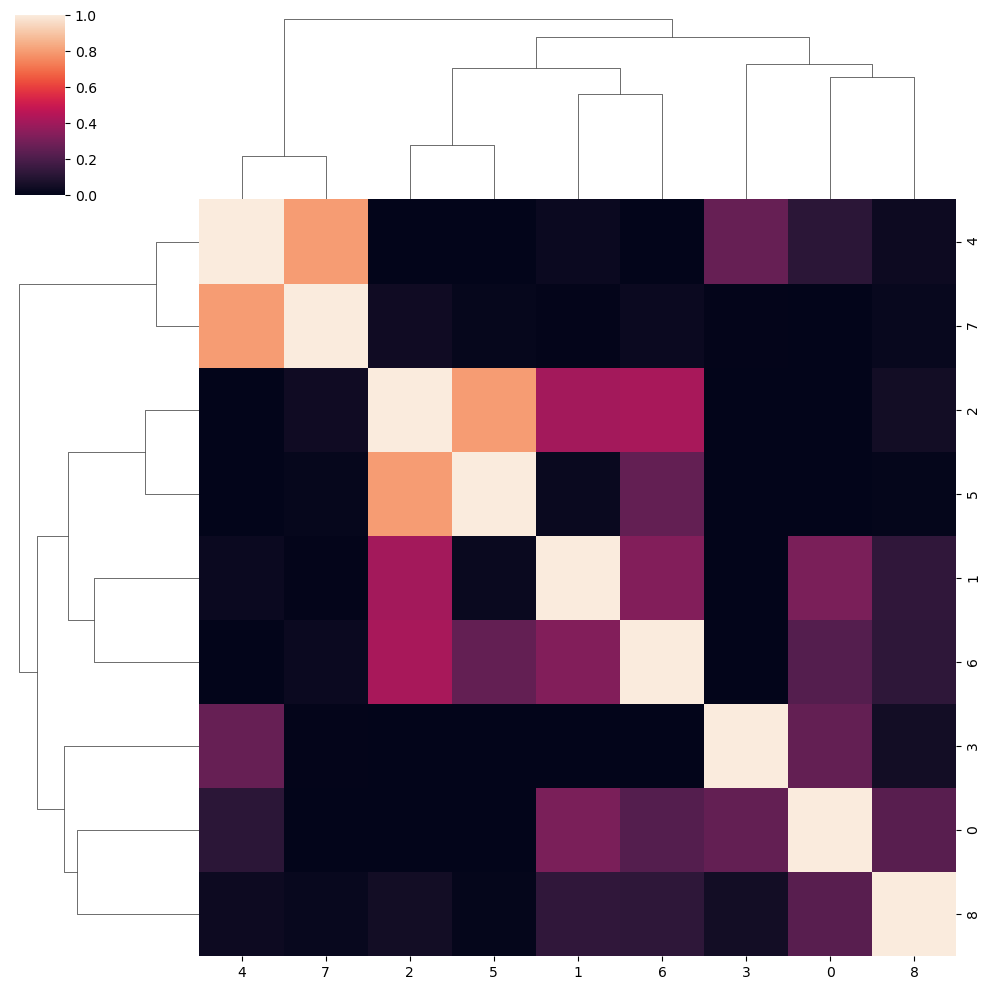

In [246]:
import seaborn as sns
sns.clustermap(norm_sim)

In [247]:
norm_sim = np.identity(norm_sim.shape[0])

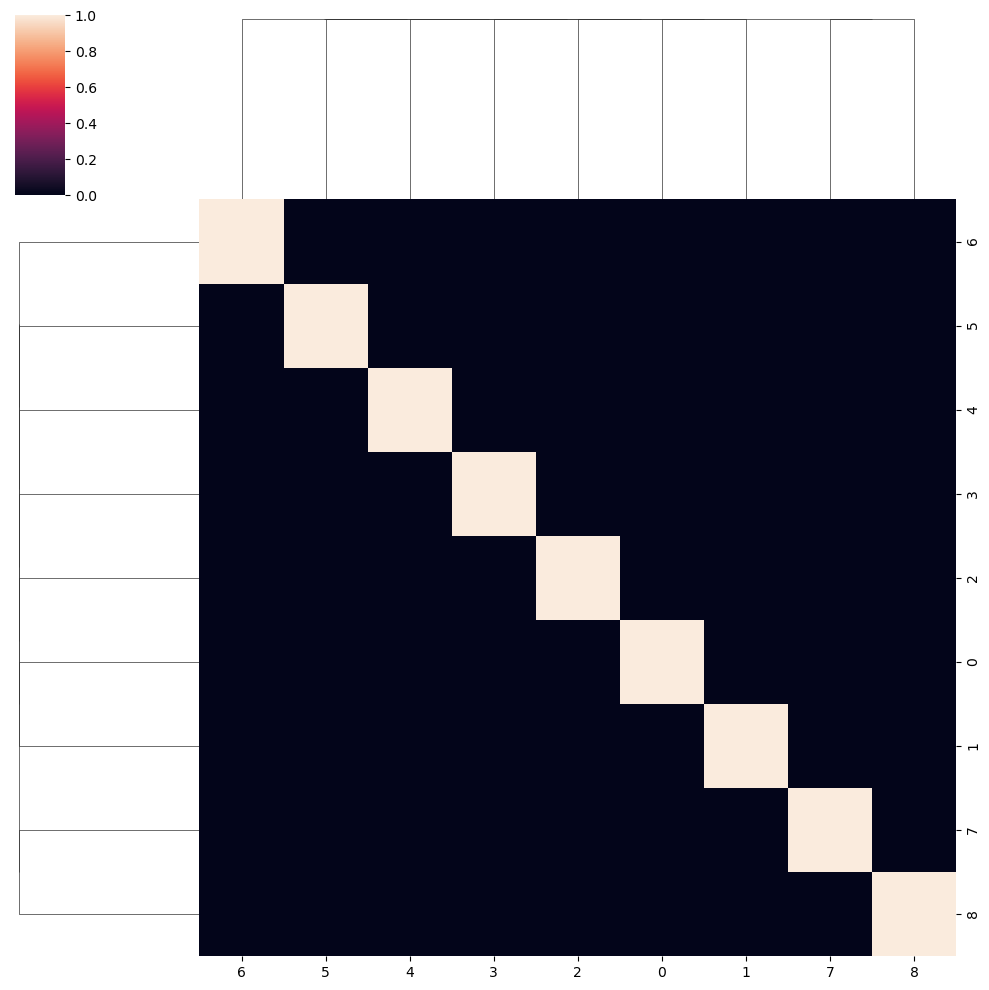

In [248]:
sns.clustermap(norm_sim)

In [249]:
norm_sim = torch.tensor(norm_sim)
norm_sim = norm_sim.to(device)

In [250]:
def weighted_loss(probabilities, norm_sim, target, weight):
        probabilities = torch.exp(probabilities) 
        similarity = torch.tensor(norm_sim[target,:]).to(device)
        level_loss=-torch.log((probabilities * similarity).sum(axis = 1))
        level_loss_weighted = level_loss * weight[target]
        reduction = (level_loss_weighted / weight[target].sum()).sum()
        return(reduction)
def check_split(y):
    #chec if all classes are present in both train and test set
    num_classes = len(y.unique()) -1
    assert sum(y[data.train_mask].unique() == y[data.train_mask].unique()) == num_classes
    

In [251]:
check_split(data.y_type)

In [252]:
check_split(data.y_clone)

In [253]:
eps = 1e-4
loss_old = 100
losses = {}
accuracy = {}
losses["clone"] = dict({"train":[],"test":[]})
losses["cell_type"] = dict({"train":[],"test":[]})
accuracy["clone"] = dict({"train":[],"test":[]})
accuracy["cell_type"] = dict({"train":[],"test":[]})
no_improv = 0
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    pred= model(data.x, data.edge_index)
    pred_clone = pred[:,:data.num_classes_clone-1]
    pred_cell_type = pred[:,data.num_classes_clone-1:]
    pred_clone = F.log_softmax(pred_clone, dim=1)
    pred_cell_type = F.log_softmax(pred_cell_type, dim=1)
    loss_clone = weighted_loss(pred_clone[data.train_mask], norm_sim, data.y_clone[data.train_mask],weight_clone)
    # loss_clone = F.nll_loss(pred_clone[data.train_mask], data.y_clone[data.train_mask], weight = weight_clone)

    losses["clone"]["train"].append(loss_clone.item())

    loss_type = F.nll_loss(pred_cell_type[data.train_mask], data.y_type[data.train_mask], weight = weight_type)
    losses["cell_type"]["train"].append(loss_type.item())
    loss = torch.log(torch.sqrt(loss_clone*loss_type))
    loss.backward()
    optimizer.step()
    
    acc_clone,acc_type, loss_clone_test,loss_ct_test = test()
    if epoch%20==0:
        print(f"epoch {epoch}: Clone prediction loss {loss_clone.item():.3f} \t Cell type prediction loss: {loss_type.item():.3f}")
        print(f"TEST: Clone accuracy {acc_clone:.4f} \t Cell type accuracy: {acc_type:.4f}")
    accuracy["clone"]["test"].append(acc_clone)
    accuracy["cell_type"]["test"].append(acc_type)
    losses["cell_type"]["test"].append(loss_ct_test.detach().cpu().item())
    losses["clone"]["test"].append(loss_clone_test.detach().cpu().item())


    # loss = loss_clone + loss_type

    if (loss_old- loss_clone.item() <eps):
        no_improv += 1
        print(f"no improvement ({no_improv})")
    else:
        no_improv = 0
    if (no_improv >10) & (epoch>100):
        print("EARLY STOPPING")
        break
    loss_old = loss_clone.item()
print("DONE")


/tmp/ipykernel_707/3178110637.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  similarity = torch.tensor(norm_sim[target,:]).to(device)


epoch 0: Clone prediction loss 2.280 	 Cell type prediction loss: 2.219
TEST: Clone accuracy 0.0830 	 Cell type accuracy: 0.2109
epoch 20: Clone prediction loss 1.443 	 Cell type prediction loss: 1.439
TEST: Clone accuracy 0.4557 	 Cell type accuracy: 0.5516
epoch 40: Clone prediction loss 1.325 	 Cell type prediction loss: 1.225
TEST: Clone accuracy 0.6081 	 Cell type accuracy: 0.6755
epoch 60: Clone prediction loss 1.262 	 Cell type prediction loss: 1.119
TEST: Clone accuracy 0.6226 	 Cell type accuracy: 0.6980
epoch 80: Clone prediction loss 1.228 	 Cell type prediction loss: 1.074
TEST: Clone accuracy 0.6157 	 Cell type accuracy: 0.7100
epoch 100: Clone prediction loss 1.207 	 Cell type prediction loss: 1.042
TEST: Clone accuracy 0.6195 	 Cell type accuracy: 0.7233
epoch 120: Clone prediction loss 1.193 	 Cell type prediction loss: 1.011
TEST: Clone accuracy 0.6107 	 Cell type accuracy: 0.7308
epoch 140: Clone prediction loss 1.181 	 Cell type prediction loss: 0.989
TEST: Clone acc

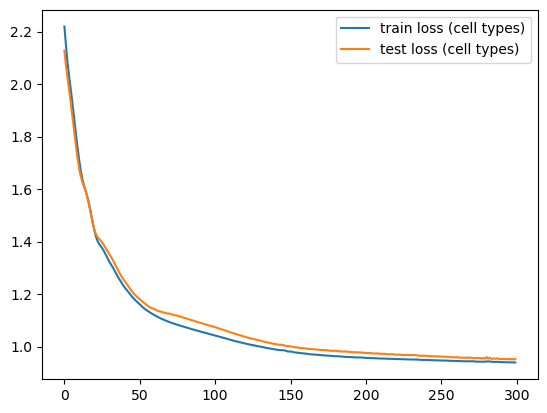

In [254]:
#plt.plot(loss_clones, label = "train loss (clones)")
plt.plot(losses["cell_type"]["train"], label = "train loss (cell types)")
plt.plot(losses["cell_type"]["test"], label = "test loss (cell types)")

plt.legend()
plt.show()

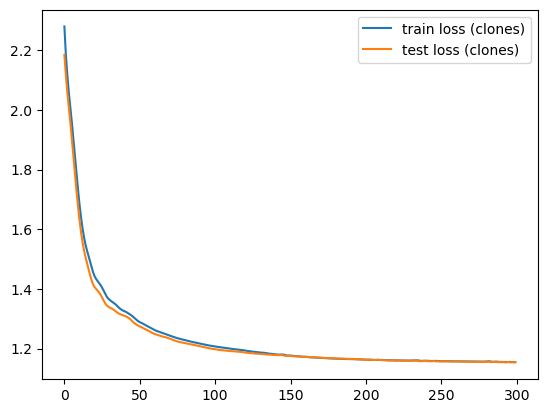

In [255]:
#plt.plot(loss_clones, label = "train loss (clones)")
plt.plot(losses["clone"]["train"], label = "train loss (clones)")
plt.plot(losses["clone"]["test"], label = "test loss (clones)")

plt.legend()
plt.show()

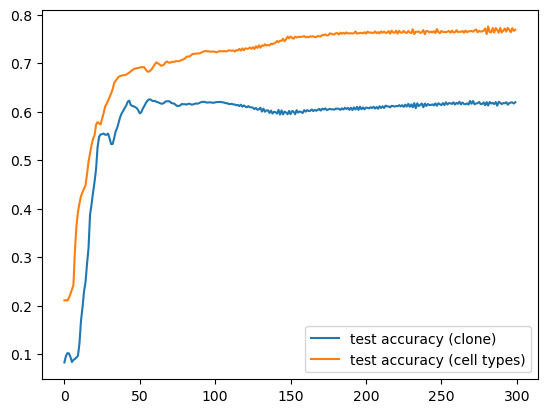

In [256]:
#plt.plot(loss_clones, label = "train loss (clones)")
plt.plot(accuracy["clone"]["test"], label = "test accuracy (clone)")
plt.plot(accuracy["cell_type"]["test"], label = "test accuracy (cell types)")

plt.legend()
plt.show()

In [257]:
model.eval()
pred = model(data.x, data.edge_index)
pred_clone = pred[:,:data.num_classes_clone-1]
pred_cell_type = pred[:,data.num_classes_clone-1:]
pred_clone = F.log_softmax(pred_clone, dim=1)
pred_clone1 = pred_clone.argmax(dim=1)
pred_cell_type = F.log_softmax(pred_cell_type, dim=1)
pred_cell_type1 = pred_cell_type.argmax(dim=1)

correct_clones = (pred_clone1[data.test_mask] == data.y_clone[data.test_mask]).sum()
correct_types = (pred_cell_type1[data.test_mask] == data.y_type[data.test_mask]).sum()

acc_clone = int(correct_clones) / len(data.test_mask)
acc_type = int(correct_types) / len(data.test_mask)

print(f'Accuracy clones: {acc_clone:.4f}')
print(f'Accuracy cell types: {acc_type:.4f}')

Accuracy clones: 0.6196
Accuracy cell types: 0.7690


In [258]:
clone_rev = {val:key for key,val in clone_dict.items()}
type_rev = {val:key for key,val in type_dict.items()}
node_encoder_rev = {val:key for key,val in node_encoder.items()}

In [259]:
pred_clone

tensor([[-2.0060, -1.5317, -1.2877,  ..., -3.1482, -5.5912, -3.8464],
        [-1.4706, -2.2987, -2.5551,  ..., -1.6723, -3.1689, -1.9101],
        [-2.2211, -1.3479, -1.0218,  ..., -4.1670, -7.1439, -4.3346],
        ...,
        [-1.2541, -1.6067, -2.2443,  ..., -4.1373, -5.5633, -1.2438],
        [-2.1188, -2.7782, -2.5753,  ..., -3.3601, -4.8812, -0.7181],
        [-1.3295, -1.3097, -1.6693,  ..., -3.4023, -4.7703, -2.7824]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [260]:
pred = model(data.x, data.edge_index)
pred_clone = pred[:,:data.num_classes_clone-1]
pred_cell_type = pred[:,data.num_classes_clone-1:]
pred_clone = np.exp(F.log_softmax(pred_clone, dim=1).detach().cpu().numpy())
pred_cell_type = np.exp(F.log_softmax(pred_cell_type, dim=1).detach().cpu().numpy())

In [261]:
pred_clone

array([[0.1345229 , 0.21617435, 0.27590623, ..., 0.04292838, 0.00373069,
        0.02135718],
       [0.2297874 , 0.10039254, 0.07768225, ..., 0.18780549, 0.04205042,
        0.14805931],
       [0.10849148, 0.2597777 , 0.35995826, ..., 0.01549934, 0.00078964,
        0.01310732],
       ...,
       [0.28533527, 0.20055673, 0.10600137, ..., 0.01596604, 0.00383593,
        0.2882738 ],
       [0.12017779, 0.06215089, 0.07613038, ..., 0.0347329 , 0.00758797,
        0.48768625],
       [0.26459962, 0.26988965, 0.1883733 , ..., 0.03329654, 0.00847784,
        0.06189209]], dtype=float32)

In [262]:
cells_hold_out =[node_encoder_rev[x.item()] for x in data.hold_out]

In [263]:
clone_res = pd.DataFrame(pred_clone[data.hold_out.detach().cpu().numpy()], index = cells_hold_out)

In [264]:
clone_res.columns =list(np.arange(pred_clone.shape[1]))[:-1] + ["diploid"]

In [265]:
ct_res = pd.DataFrame(pred_cell_type[data.hold_out.detach().cpu().numpy()], index = cells_hold_out)
ct_res.columns = [type_rev[x] for x in ct_res.columns]

In [266]:
import scanpy as sc


In [267]:
path = "../data/raw/visium/"
visium = sc.read_visium(path, genome=None, count_file='CytAssist_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5',
                        library_id=None, load_images=True, source_image_path=None)
visium.var_names_make_unique()

/home/o313a/miniconda3/envs/torch_geo/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [268]:
coor_int = [[int(x[0]),int(x[1])] for x in visium.obsm["spatial"]]
visium.obsm["spatial"] = np.array(coor_int)

In [269]:
clones_columns = clone_res.columns
ct_columns = ct_res.columns

In [270]:
visium.obs = visium.obs.join(clone_res).join(ct_res)

In [271]:
visium.obs["clone"] = visium.obs[clones_columns].idxmax(axis = 1)

In [272]:
visium.obs["clone"].unique()

array([4, 3, 'diploid', 2, 0, 7, 5, 6, 1], dtype=object)

In [273]:
visium.obs.clone = visium.obs.clone.astype("str")

In [274]:
import matplotlib as mpl


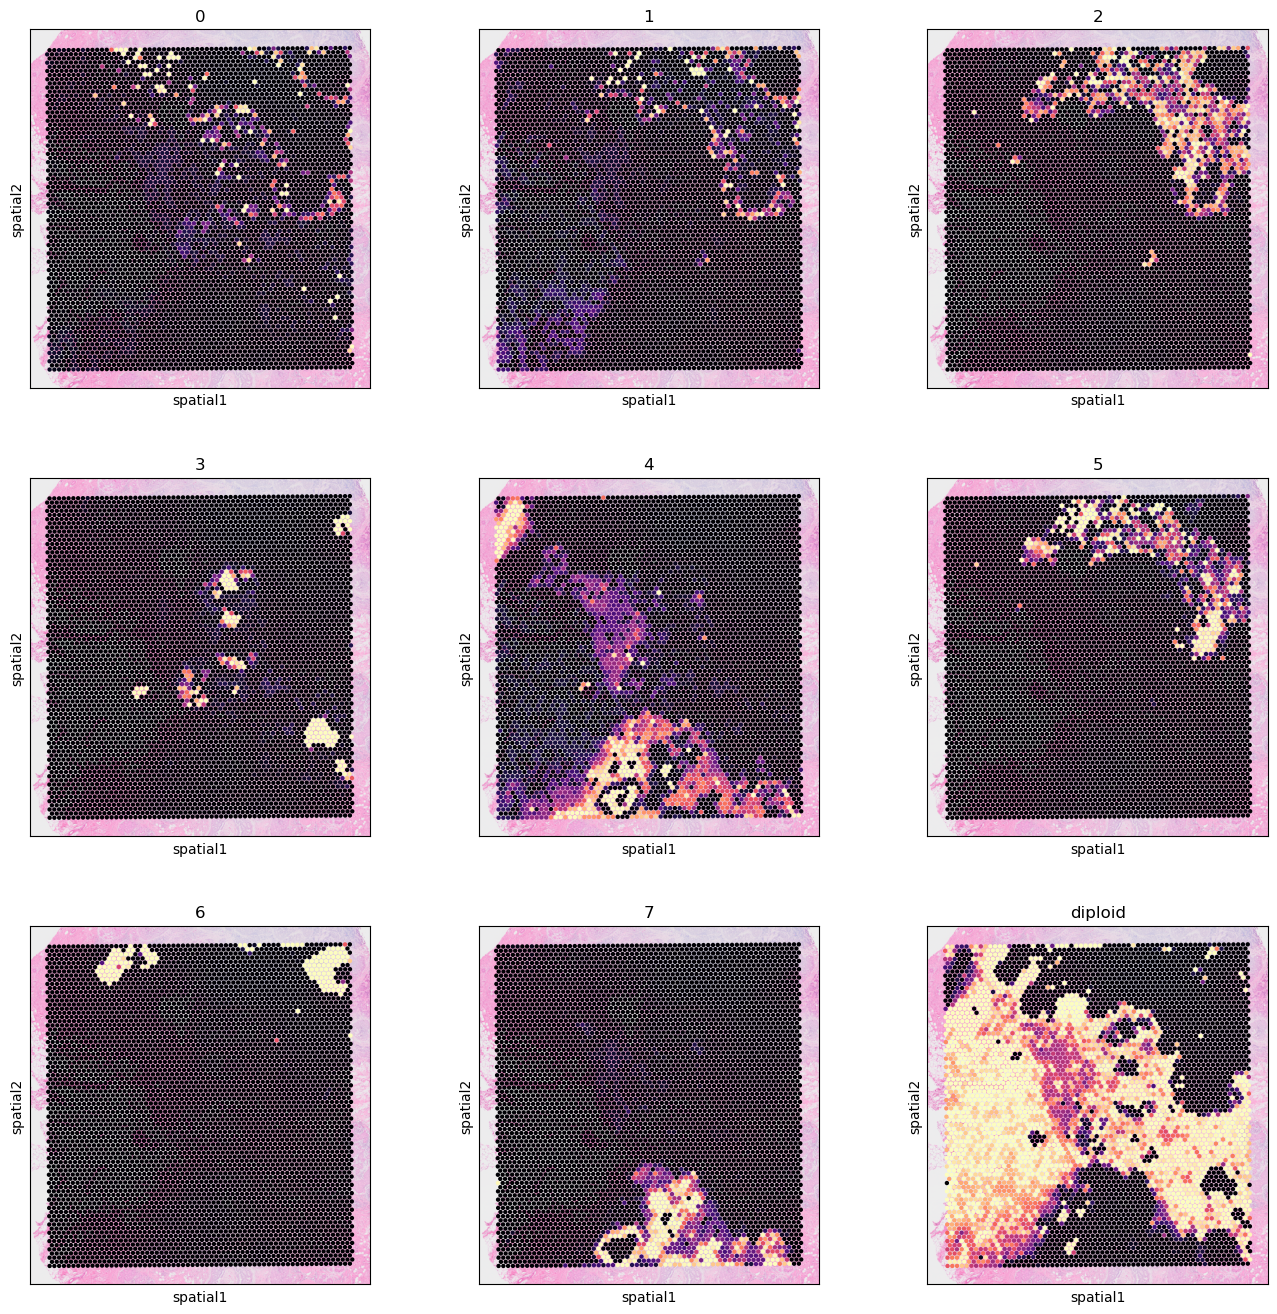

In [275]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color=clones_columns,
                  ncols=3, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  colorbar_loc = None
                 )

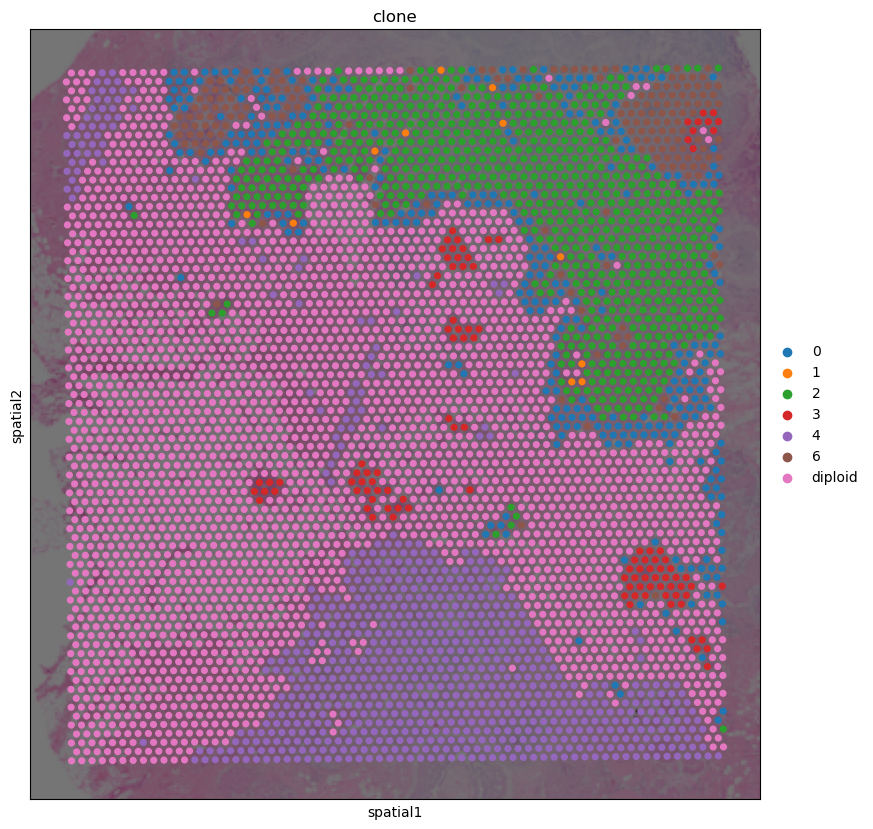

In [236]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [10, 10]}):
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="clone",
                img_key='lowres', alpha_img = 0.5,
                 )

In [237]:
visium.obs["cell_type"] = visium.obs[ct_columns].idxmax(axis = 1)

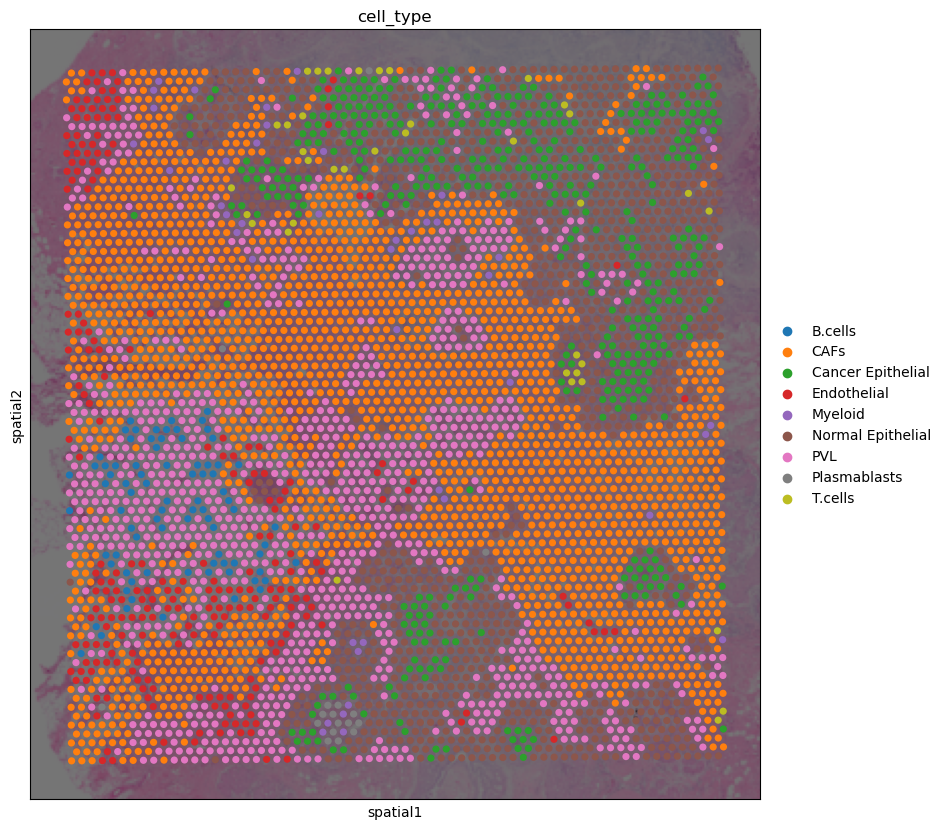

In [238]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [10, 10]}):
    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color="cell_type",
                img_key='lowres', alpha_img = 0.5,
                 )

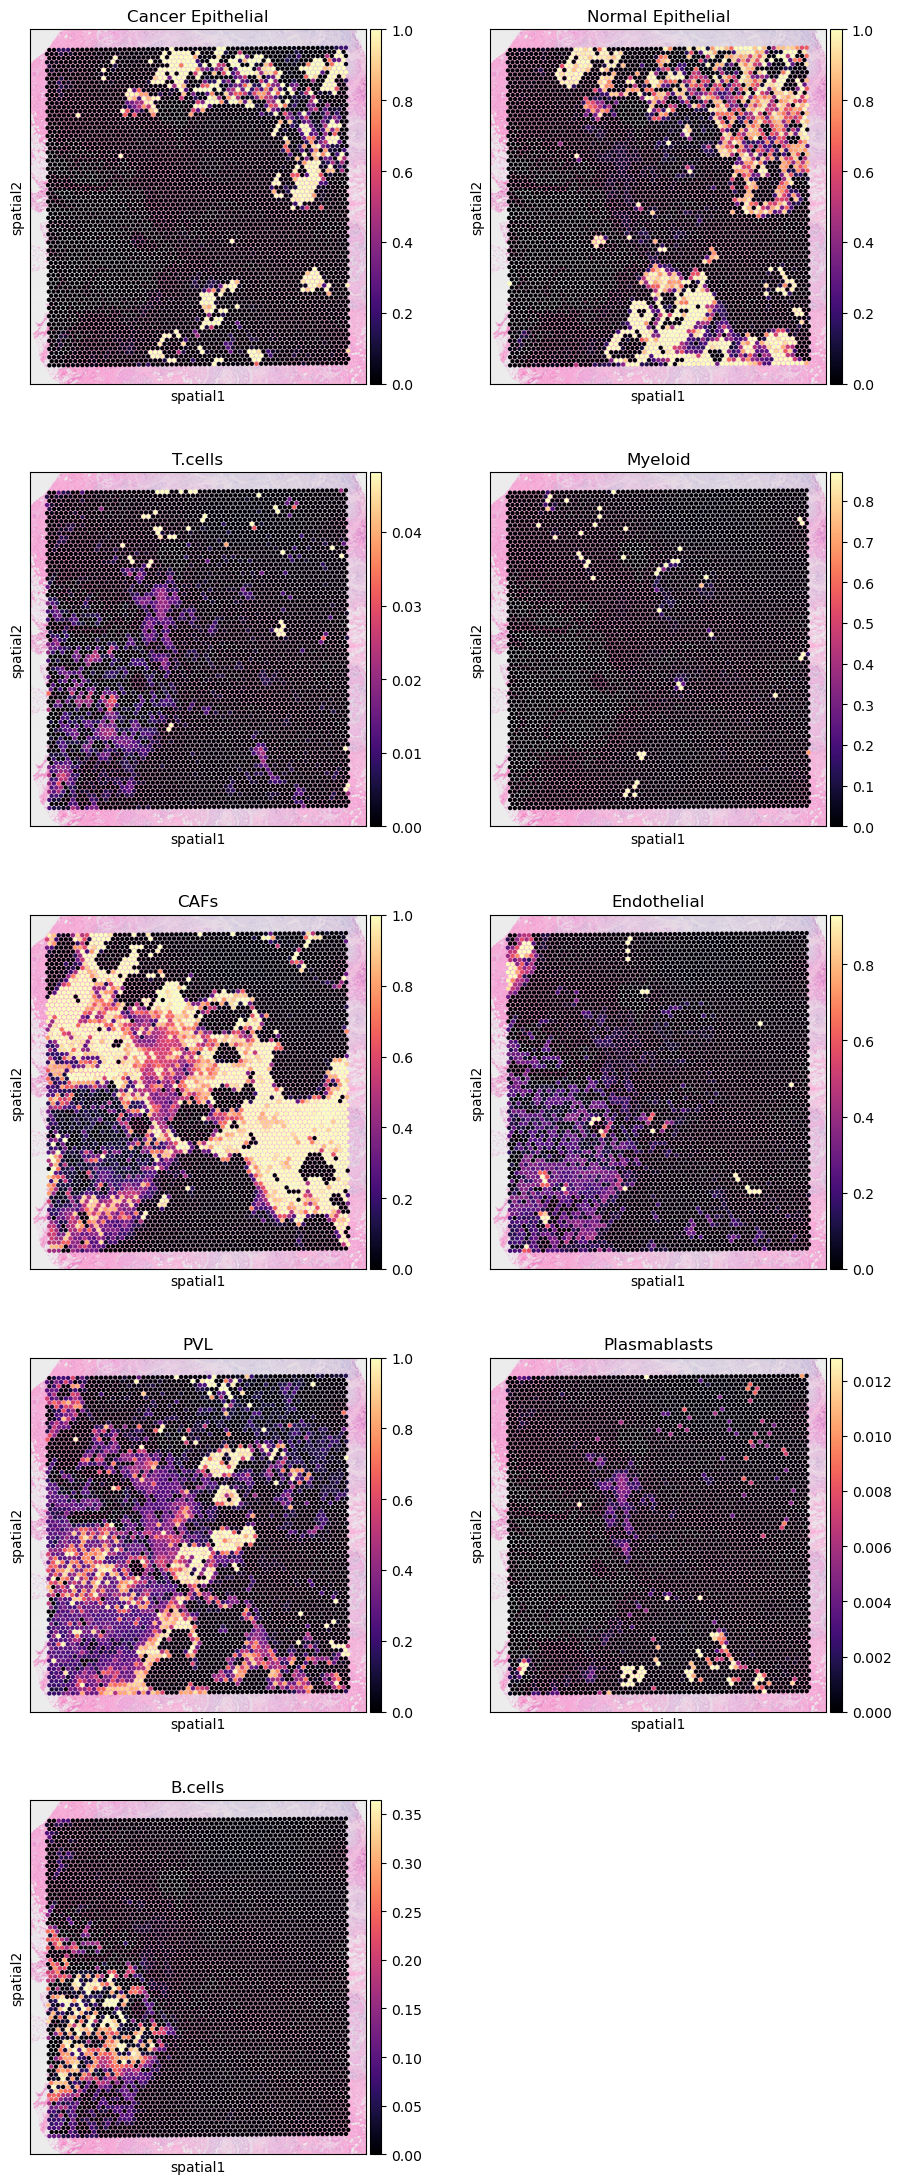

In [239]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(visium, cmap='magma',
                  # show first 8 cell types
                  color=ct_columns,
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2',
                  show=False
                 )